In this project we propose to create an item-item recommendation system that will assist users in selecting the next title to watch based on their input of a specific title. We will adopt this approach instead of building user profiles, so the imputed title will be used in lieu of a user profile, however user profile data is available that we may incorporate into our project later, time allowing.

We have begun setting up our item-item system, but we have not progressed very far. We are currently using a truncated version of our ratings file.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

ratings_df = pd.read_csv("./input/ratings_small.csv", dtype = 'float')
ratings_df.head()

movies_df = pd.read_csv("./input/movies_metadata.csv")
movies_df.head()

movies_df = movies_df[movies_df['id'].astype(str).str.isdigit()] # clean (Some movies have not integers as id)
movies_df.id = movies_df.id.astype(np.int64)

ratings_df = pd.merge(ratings_df,movies_df[['title','id']],left_on='movieId',right_on='id')
ratings_df.head()

ratings_df.drop(['timestamp','id'],axis=1,inplace=True)

titles = ratings_df["title"].unique()
titlesRate = []
titlesVote = []

for t in range(len(titles)):
    temp = ratings_df[(ratings_df["title"] == titles[t])]
    v = temp['rating'].mean()
    titlesVote.append(temp['rating'].count())
    titlesRate.append(v)

data = {'Title':  titles,
        'Rating': titlesRate,
        'Votes': titlesVote
       }
Leaderboard = pd.DataFrame (data, columns = ['Title','Rating','Votes'])


C:\Users\Kathleen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3156: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# Highly rated movies
print("Top rated movies")
Leaderboard = Leaderboard.sort_values(by=['Rating','Votes'], ascending = False).reset_index(drop = True)
print(Leaderboard.head(10))

print("Most viewed movies")
# Popular
Leaderboard = Leaderboard.sort_values(by=['Votes','Rating'], ascending = False).reset_index(drop = True)
print(Leaderboard.head(10))

Top rated movies
                      Title  Rating  Votes
0           The Celebration     5.0      3
1   The Night of the Hunter     5.0      3
2                 Ninotchka     5.0      2
3                 Silentium     5.0      2
4  Gentlemen Prefer Blondes     5.0      2
5                 Long Pigs     5.0      2
6              Nick of Time     5.0      1
7        The Crazy Stranger     5.0      1
8            The Inquisitor     5.0      1
9      Murder in Three Acts     5.0      1
Most viewed movies
                                Title    Rating  Votes
0  Terminator 3: Rise of the Machines  4.256173    324
1            The Million Dollar Hotel  4.487138    311
2                             Solaris  4.134426    305
3                        The 39 Steps  4.221649    291
4                     Monsoon Wedding  3.706204    274
5                  Once Were Warriors  4.303279    244
6                   Three Colors: Red  3.945175    228
7                     Men in Black II  4.256696    

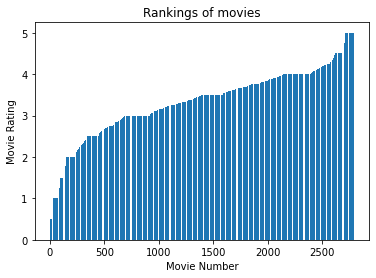

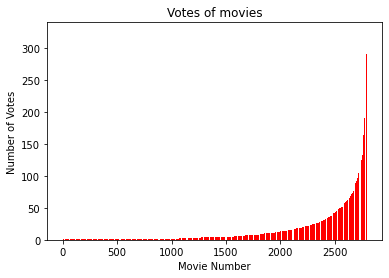

In [3]:
top_rated_movies = Leaderboard.sort_values(by=['Rating','Votes'], ascending = False).reset_index(drop = True)
top_rated_movies_y = sorted(top_rated_movies['Rating'].values.tolist())
top_rated_movies_x = [i for i in range(len(top_rated_movies_y))]

plt.bar(top_rated_movies_x, top_rated_movies_y)

plt.title('Rankings of movies')
plt.xlabel("Movie Number")
plt.ylabel("Movie Rating")
plt.show()

top_voted_movies_y = sorted(top_rated_movies['Votes'].values.tolist())
top_voted_movies_x = [i for i in range(len(top_rated_movies_y))]
plt.bar(top_voted_movies_x, top_voted_movies_y, color = 'red')

plt.title('Votes of movies')
plt.xlabel("Movie Number")
plt.ylabel("Number of Votes")
plt.show()


As you can see, we have cleaned and merged some data from our csv files. From these we calculated the most popular and high rated titles, as well as averages of the like. This is very important for recomendations! The better rated and ranked an item, the more likely it is to be recommended. It also is important to think about which items are popular in general and which items are specifically. Moving foward we will have to  run knn on the movies. Where the closest k movies will be suggested. Perhaps we can incorporate the rating of the movie in the way we list the movie recommendations to the user. 

In [13]:
import re
import unidecode

movie_text = movies_df['overview'].values.tolist()
movie_text_check = movie_text.copy()
# clean up punctuation
movie_text = [set(re.sub(r'[^a-zA-Z0-9\s]','', unidecode.unidecode(str(movie_text_check[i]))).split()) for i in range(len(movie_text))]

# movie_text = [set(str(movie_text[i]).split()) for i in range(len(movie_text))]

movie_title = movies_df['original_title'].values.tolist()
movie_title = [movie_title[i] for i in range(len(movie_title))]
movie_title_set = set(movie_title)

movie_word_set = {movie_title[i]: movie_text[i] for i in range(len(movie_title))}
check_words = {movie_title[i]: movie_text_check[i] for i in range(len(movie_title))}


In [5]:
# adult_store = {collection_titles[i] : c for i,c in enumerate(adult)}

def description_similarity(title, title_set = movie_title_set, return_scores = False, return_text = False, return_all = False):
    if title not in title_set:
        print("Title not found!")
        return []
    
    else:
        # get descirption of corresponding movie form dictionary
        title_set = movie_word_set[title]

        current_leader = []
        for j, m_title in enumerate(movie_title):

            description_sim = len(movie_text[j].intersection(title_set))/len(movie_text[j].union(title_set))
    
            if return_text:
                current_leader.append((movie_title[j],description_sim, movie_text[j]))
            else:
                current_leader.append((movie_title[j], description_sim))
               
        current_leader.sort(key = lambda x:x[1], reverse = True)
        current_leader = current_leader[1:]

        # only use top 10 similar movies
        if return_all==False:
            current_leader = current_leader[:10]
            
        if return_scores or return_text:
            return current_leader
        
        # return just the titles
        else:
            return [x[0] for x in current_leader]
        
title = "Toy Story"
temp = np.array(description_similarity(title, return_scores = True, return_all=False))
# print([(x[0], x[1]) for x in temp])
print(temp)



[['Toy Story 2' '0.16883116883116883']
 ['Giù la testa... hombre' '0.16176470588235295']
 ['Vipère au poing' '0.15384615384615385']
 ['Ultimate Avengers 2' '0.15']
 ['Les Fugitifs' '0.14925373134328357']
 ['The Jungle Book 2' '0.14545454545454545']
 ['The Hooligan Factory' '0.14285714285714285']
 ['Spy Game' '0.14102564102564102']
 ['Free Birds' '0.14102564102564102']
 ['Che!' '0.14102564102564102']]


In [12]:
title1 = 'Toy Story'
if title1 in check_words:
    print(check_words[title1])
print()
title2 = 'Toy Story 2'
if title2 in check_words:
    print(check_words[title2])
        
ii = movie_title.index(title1)
title_set = movie_text[ii]

iii = movie_title.index(title2)
title_set_two = movie_text[iii]

print(title_set.intersection(title_set_two))
print()
print(len(title_set.intersection(title_set_two)),len(title_set.union(title_set_two)))
# print(len(title_set.union(title_set_two)),len(title_set) + len(title_set_two))

Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.

Andy heads off to Cowboy Camp, leaving his toys to their own devices. Things shift into high gear when an obsessive toy collector named Al McWhiggen, owner of Al's Toy Barn kidnaps Woody. Andy's toys mount a daring rescue mission, Buzz Lightyear meets his match and Woody has to decide where he and his heart truly belong.
{'Lightyear', 'and', 'of', 'toys', 'heart', 'to', 'his', 'owner', 'Woody', 'Andys', 'when', 'their', 'Buzz'}

13 77


In [7]:
collection = movies_df['belongs_to_collection']
collection_titles = movies_df['original_title'].values.tolist()
collection_store = {collection_titles[i] : ast.literal_eval(c)['name'] if isinstance(c, str) else None for i,c in enumerate(collection.values.tolist())}

def collection_similarity(title, title_collection = None, return_all = False):
    temp = []
    
    if title_collection is None:
            title_collection = collection_store[title]
            
    for i in range(len(movie_title)):
        
        if movie_title[i] == title:
            temp.append((movie_title[i],1))
            continue
            
        if collection_store[movie_title[i]] is not None:           
            if collection_store[movie_title[i]] == title_collection:
                temp.append((movie_title[i],0))
                
            else:
                temp.append((movie_title[i],1))
        else:
            temp.append((movie_title[i],1))
            
#     temp.sort(key = lambda x:x[1])  
    
    if return_all:
        return temp
    else:
        return temp[:10]
        
print(collection_similarity('Toy Story'))


[('Toy Story', 1), ('Jumanji', 1), ('Grumpier Old Men', 1), ('Waiting to Exhale', 1), ('Father of the Bride Part II', 1), ('Heat', 1), ('Sabrina', 1), ('Tom and Huck', 1), ('Sudden Death', 1), ('GoldenEye', 1)]


In [8]:
adult = movies_df['adult'].values.tolist()
adult_store = {collection_titles[i] : c for i,c in enumerate(adult)}

def adult_similarity(title, title_collection = None, return_all = False):
    temp = []
    
    if title_collection is None:
            title_collection = adult_store[title]
            
    for i in range(len(movie_title)):
        
        if movie_title[i] == title:
            temp.append((movie_title[i],1))
            continue
            
        if adult_store[movie_title[i]] is not None:           
            if adult_store[movie_title[i]] == title_collection:
                temp.append((movie_title[i],0))
            else:
                temp.append((movie_title[i],1))
        else:
            temp.append((movie_title[i],1))
            
#     temp.sort(key = lambda x:x[1])  
    
    if return_all:
        return temp
    else:
        return temp[:10]
        
print(adult_similarity('Toy Story'))


[('Toy Story', 1), ('Jumanji', 0), ('Grumpier Old Men', 0), ('Waiting to Exhale', 0), ('Father of the Bride Part II', 0), ('Heat', 0), ('Sabrina', 0), ('Tom and Huck', 0), ('Sudden Death', 0), ('GoldenEye', 0)]


In [9]:
language = movies_df['original_language'].values.tolist()
language_store = {collection_titles[i] : c for i,c in enumerate(language)}

def language_similarity(title, title_collection = None, return_all = False):
    temp = []
    
    if title_collection is None:
            title_collection = adult_store[title]
            
    for i in range(len(movie_title)):
        
        if movie_title[i] == title:
            temp.append((movie_title[i],1))
            continue
            
        if language_store[movie_title[i]] is not None:           
            if language_store[movie_title[i]] == title_collection:
                temp.append((movie_title[i],0))
                
            else:
                temp.append((movie_title[i],1))
        else:
            temp.append((movie_title[i],1))
            
#     temp.sort(key = lambda x:x[1])  
    
    if return_all:
        return temp
    else:
        return temp[:10]
        
print(language_similarity('Toy Story'))


[('Toy Story', 1), ('Jumanji', 1), ('Grumpier Old Men', 1), ('Waiting to Exhale', 1), ('Father of the Bride Part II', 1), ('Heat', 1), ('Sabrina', 1), ('Tom and Huck', 1), ('Sudden Death', 1), ('GoldenEye', 1)]


In [10]:
genre = movies_df['genres'].values.tolist()
genre_list = [ast.literal_eval(c) for i,c in enumerate(genre)]

# print(genre_list)

genre_store = {}

for i,arr in enumerate(genre_list):
    genre_store[movie_title[i]] = set()
    for d in arr:
        genre_store[movie_title[i]].add(d['name'])

def genre_similarity(title, title_collection = None, return_all = False):
    temp = []
    
    if title_collection is None:
            title_collection = genre_store[title]
            
    for i in range(len(movie_title)):
        
        if movie_title[i] == title:
            temp.append((movie_title[i],1))
            continue
            
        if genre_store[movie_title[i]] is not None:           
            temp.append((movie_title[i],2*(len(genre_store[movie_title[i]].union(genre_store[title]))/(len(genre_store[movie_title[i]])+len(genre_store[title]))-0.5)))
                  
        else:
            temp.append((movie_title[i],1))
    
    if return_all:
        return temp
    else:
        temp.sort(key = lambda x:x[1])
        return temp[:10]
        
print(genre_similarity('Batman v Superman: Dawn of Justice'))

print(genre_store['Batman v Superman: Dawn of Justice'], genre_store['The Scorpion King'])

[('Highlander', 0.0), ('Hercules', 0.0), ('Conan the Barbarian', 0.0), ('Red Sonja', 0.0), ('The 13th Warrior', 0.0), ('The Mummy Returns', 0.0), ('Krull', 0.0), ('The Lord of the Rings: The Fellowship of the Ring', 0.0), ('Conan the Destroyer', 0.0), ('The Scorpion King', 0.0)]
{'Fantasy', 'Action', 'Adventure'} {'Fantasy', 'Action', 'Adventure'}


In [14]:
def combine(title, scores = [5,2,5,5,2]):
    collection = collection_similarity(title, return_all = True)
    description = description_similarity(title, return_scores = True, return_all = True)
    language = language_similarity(title, return_all = True)
    adult = adult_similarity(title, return_all = True)
    genre = genre_similarity(title, return_all = True)
#     for i in range(1,len(description)):
#         if description[i-1][0] == description[i][0]:
#             description = description[:i-1] + description[i:]
#             break
    print(len(collection), len(description), len(language), len(adult), len(genre))
    temp = []
    
    for i in range(len(movie_title)-2):
        
        if movie_title[i] == title or movie_title[i] not in adult_store:
            continue
#         print(scores[0]*adult[i][1])
#         print(scores[0]*language[i][1])
#         print(scores[0]*collection[i][1])
#         print(adult[i][1], language[i][1], collection[i][1], description[i][1])
#         print(adult[i][0],"  ", language[i][0], "  ",  collection[i][0], "  ", description[i][0])
#         print(movie_title[i], scores[0]*adult[i+1][1], scores[1]*language[i+1][1], scores[2]*collection[i+1][1], scores[3]*description[i+1][1], scores[0]*adult[i+1][1] + scores[1]*language[i+1][1] + scores[2]*collection[i+1][1] + scores[3]*description[i+1][1])
        temp.append((movie_title[i],scores[0]*adult[i][1] + scores[1]*language[i][1] + scores[2]*collection[i][1] + scores[3]*description[i][1] + scores[4]*genre[i][1]))
    temp.sort(key = lambda x:x[1])
    return temp[:10]

print(combine("Toy Story"))

45463 45462 45463 45463 45463
[('Toy Story 3', 2.3636363636363638), ('Toy Story 2', 2.4761904761904763), ('Боцман и попугай', 7.0), ('The Great Piggy Bank Robbery', 7.0), ('Ali Baba Bunny', 7.0), ('Feed the Kitty', 7.0), ('Devil May Hare', 7.0), ('Banana', 7.0), ('The Emoji Movie', 7.0), ('Minions: Orientation Day', 7.0)]
